In [28]:
# limit the thread used by numpy 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  

import numpy as np
import scipy.interpolate as interp 
try:
    import cupy as xp
    import cupyx.scipy.interpolate as xinterp
    # print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    import scipy.interpolate as xinterp  
    # print("no cupy")

from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

from Triangle.Constants import *
from Triangle.Orbit import * 
from Triangle.Noise import *
from Triangle.FFTTools import *
from Triangle.TDI import *
from Triangle.Data import * 

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import *
from Triangle_BBH.Utils import *
from Triangle_BBH.Fisher import *

# import multiprocessing

# np.random.seed(114514)
# xp.random.seed(114514)

## Data settings 

In [29]:
t_start = 10. * DAY # start time in s
Tobs = 5. * DAY # data length in s 
t_end = t_start + Tobs # end time in s 
dt = 10. # time cadance in s 
fsample = 1. / dt # sampling rate in Hz 
data_frequencies = np.fft.rfftfreq(n=int(Tobs/dt), d=dt) # frequecies where waveform will be calculated 
delta_f = 1. / Tobs

data_frequencies.shape 

(21601,)

In [30]:
# mask the "null" frequencies, which may cause singularity in the calculation of likelihood 
mask = np.ones_like(data_frequencies, dtype=bool)
for i in range(1, 40): 
    mask_idx = np.where(np.abs(data_frequencies - i*0.025)<i*3e-4)[0]
    mask[mask_idx] = False 
data_frequencies = data_frequencies[mask]

# remove the frequencies below Taiji sensitive band 
mask = np.where(data_frequencies > 1e-5)[0]
data_frequencies = data_frequencies[mask]
data_frequencies_GPU = xp.array(data_frequencies)

data_frequencies.shape 

(21077,)

## Set response model 

In [31]:
# the path of Taiji orbit 
orbit_GPU = Orbit(OrbitDir="../../Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB") # create individial orbit objects for CPU and GPU to avoid the confusion of numpy / cupy orbit data 

# initialize  waveform generator 
WFG_GPU = BBHxWaveformGenerator(mode="primary", use_gpu=True)

# initialize response generator 
FDTDI_GPU = BBHxFDTDIResponseGenerator(orbit_class=orbit_GPU, waveform_generator=WFG_GPU, use_gpu=True)

# response settings 
response_kwargs_GPU = dict(
    modes=[(2,2)], 
    tmin=t_start / DAY, # start time in day 
    tmax=t_end / DAY, # end time in day  
    TDIGeneration="2nd", # "1st" or "2nd"
    optimal_combination=True, # True for AET, False for XYZ 
    output_by_mode=False, 
    interpolation=True,
)

## Waveform generation 

In [32]:
mbhb_parameters = {
    'chirp_mass': np.power(10., np.random.uniform(5.5, 6.5)), # [Solar mass], for chirp_mass of 10^5 or smaller, a smaller dt is needed
    'mass_ratio': np.random.uniform(0.1, 1.), 
    'spin_1z': np.random.uniform(-0.99, 0.99),
    'spin_2z': np.random.uniform(-0.99, 0.99),
    'coalescence_time': np.random.uniform(t_start + 3. * DAY, t_end) / DAY, # [day], start from t_start to ensure that at least 1-day waveform is within the data
    'coalescence_phase': np.random.uniform(0, TWOPI),
    'luminosity_distance': np.power(10., np.random.uniform(4., 5.)), # [MPC]
    'inclination': np.arccos(np.random.uniform(-1., 1.)), # [rad]
    'longitude': np.random.uniform(0, TWOPI), # [rad]
    'latitude': np.arcsin(np.random.uniform(-1., 1.)), # [rad]
    'psi': np.random.uniform(0, PI) # [rad]
    }
mbhb_parameters

{'chirp_mass': 521637.04439824284,
 'mass_ratio': 0.16922896640748814,
 'spin_1z': -0.7194019305921477,
 'spin_2z': -0.29062389607873584,
 'coalescence_time': 13.071193927362142,
 'coalescence_phase': 0.8776822891016764,
 'luminosity_distance': 13878.522474757385,
 'inclination': 1.605293256574217,
 'longitude': 3.706707335028864,
 'latitude': 0.20056018449895902,
 'psi': 2.3804577698441056}

In [33]:
wf_channels = FDTDI_GPU.Response(mbhb_parameters, data_frequencies_GPU, **response_kwargs_GPU)
wf_channels.shape 

(3, 21077)

## Noise generation 

In [34]:
arm_time = (t_start + t_end) / 2. 
arms = dict()
for key in MOSA_labels:
    arms[key] = orbit_GPU.LTTfunctions()[key](arm_time)
# print("arm lengths:", arms)

# theoretical PSDs at the given armlengths 
PSDfunc = TDIPSDs()
PSD_channels = np.array([
    PSDfunc.PSD_A2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_E2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_T2_unequal(data_frequencies, arms)
])

# generate frequency-domain noises as Gaussian and stationary 
Re_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
Im_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
noise_channels = xp.array(Re_tmp + 1.j * Im_tmp) 

# covariance matrix 
CovMat = np.array([
    [PSD_channels[0], np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), PSD_channels[1], np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0]), PSD_channels[2]]
]) / 4. / delta_f # (3, 3, Nf)

# inverse of covmatrix
InvCovMat = np.linalg.inv(np.transpose(CovMat, (2, 0, 1))) # (Nf, 3, 3)
InvCovMat[:, 2, 2] *= 0. # use A, E channels only in the following analysis 

PSD_channels.shape, noise_channels.shape, InvCovMat.shape 

((3, 21077), (3, 21077), (21077, 3, 3))

In [35]:
opt_SNR = FrequencyDomainCovarianceSNR(wf_channels.get(), InvCovMat)
opt_SNR

880.6319034212693

## Data combination 

In [36]:
data_channels = wf_channels + noise_channels 

Text(0, 0.5, 'Frequency-domain data (1/Hz)')

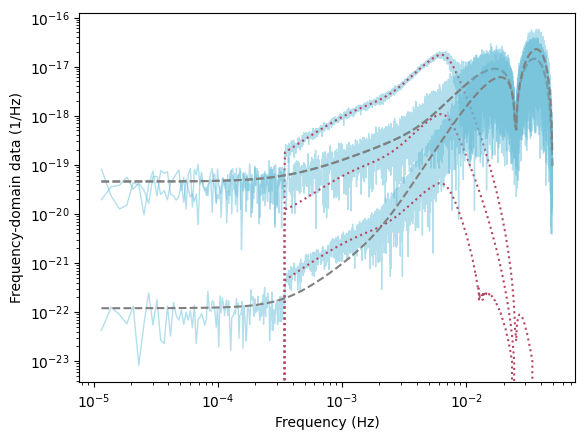

In [37]:
for ichannel, nchannel in enumerate(["A", "E", "T"]): 
    plt.loglog(data_frequencies, np.abs(data_channels[ichannel].get()), linewidth=1, alpha=0.5, color=BLUE)
    plt.loglog(data_frequencies, np.abs(wf_channels[ichannel].get()), color=RED, linestyle=":")
    plt.loglog(data_frequencies, np.sqrt(PSD_channels[ichannel] * Tobs / 2.), color="grey", linestyle="--")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Frequency-domain data (1/Hz)")

## Rapid search phase 

### initialize $\mathcal{F}$-stat and likelihood

In [38]:
Fstat = Fstatistics(
    response_generator=FDTDI_GPU, 
    frequency=data_frequencies_GPU, 
    data=data_channels, 
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs_GPU, 
    use_gpu=True 
)

Like = Likelihood(
    response_generator=FDTDI_GPU, 
    frequency=data_frequencies_GPU, 
    data=data_channels,
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs_GPU, 
    use_gpu=True,
)

number of freuqncies: 21077
min and max frequencies: 1.1574074074074073e-05 0.04939814814814815
response kwargs: {'modes': [(2, 2)], 'tmin': 10.0, 'tmax': 15.0, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False, 'interpolation': True}
number of freuqncies: 21077
min and max frequencies: 1.1574074074074073e-05 0.04939814814814815
response kwargs: {'modes': [(2, 2)], 'tmin': 10.0, 'tmax': 15.0, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False, 'interpolation': True}


### compare $\mathcal{F}$-stat and likelihood around truths

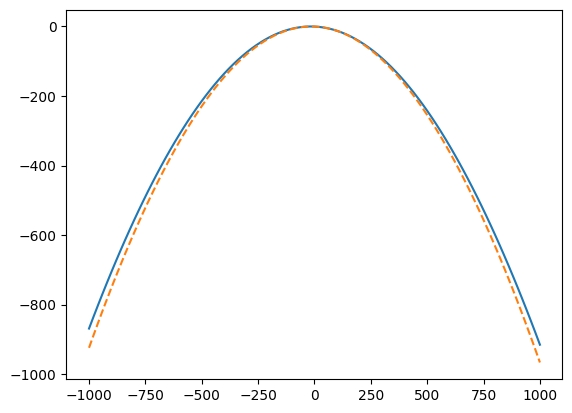

In [39]:
Ntest = 101

test_int_params = copy.deepcopy(mbhb_parameters)
for key in Fstatistics.extrinsic_parameter_names:
    test_int_params.pop(key)
for k, v in test_int_params.items():
    test_int_params[k] = np.ones(Ntest) * v 
test_int_params["chirp_mass"] = mbhb_parameters["chirp_mass"] + np.linspace(-1000, 1000, Ntest)
test_F = Fstat.calculate_Fstat_vectorized(test_int_params)

test_params = copy.deepcopy(mbhb_parameters)
for k, v in test_params.items():
    test_params[k] = np.ones(Ntest) * v 
test_params["chirp_mass"] = test_int_params["chirp_mass"].copy() 
test_L = Like.full_log_like_vectorized(ParamDict2ParamArr(test_params))

plt.plot(test_int_params["chirp_mass"] - mbhb_parameters["chirp_mass"], test_F - np.max(test_F))
plt.plot(test_int_params["chirp_mass"] - mbhb_parameters["chirp_mass"], test_L - np.max(test_L), linestyle="--")

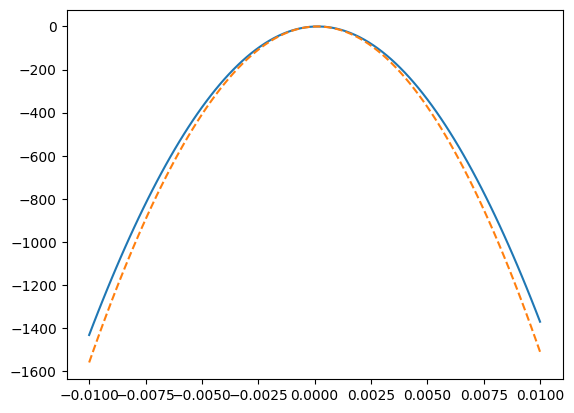

In [40]:
Ntest = 101

test_int_params = copy.deepcopy(mbhb_parameters)
for key in Fstatistics.extrinsic_parameter_names:
    test_int_params.pop(key)
for k, v in test_int_params.items():
    test_int_params[k] = np.ones(Ntest) * v 
test_int_params["spin_1z"] = mbhb_parameters["spin_1z"] + np.linspace(-0.01, 0.01, Ntest)
test_F = Fstat.calculate_Fstat_vectorized(test_int_params)

test_params = copy.deepcopy(mbhb_parameters)
for k, v in test_params.items():
    test_params[k] = np.ones(Ntest) * v 
test_params["spin_1z"] = test_int_params["spin_1z"].copy() 
test_L = Like.full_log_like_vectorized(ParamDict2ParamArr(test_params))

plt.plot(test_int_params["spin_1z"] - mbhb_parameters["spin_1z"], test_F - np.max(test_F))
plt.plot(test_int_params["spin_1z"] - mbhb_parameters["spin_1z"], test_L - np.max(test_L), linestyle="--")

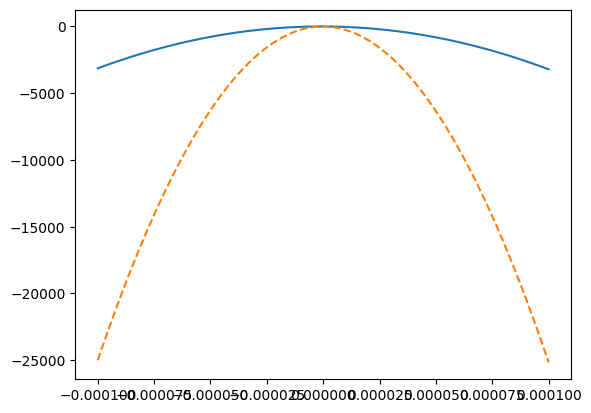

In [41]:
Ntest = 101

test_int_params = copy.deepcopy(mbhb_parameters)
for key in Fstatistics.extrinsic_parameter_names:
    test_int_params.pop(key)
for k, v in test_int_params.items():
    test_int_params[k] = np.ones(Ntest) * v 
test_int_params["coalescence_time"] = mbhb_parameters["coalescence_time"] + np.linspace(-1e-4, 1e-4, Ntest)
test_F = Fstat.calculate_Fstat_vectorized(test_int_params)

test_params = copy.deepcopy(mbhb_parameters)
for k, v in test_params.items():
    test_params[k] = np.ones(Ntest) * v 
test_params["coalescence_time"] = test_int_params["coalescence_time"].copy() 
test_L = Like.full_log_like_vectorized(ParamDict2ParamArr(test_params))

plt.plot(test_int_params["coalescence_time"] - mbhb_parameters["coalescence_time"], test_F - np.max(test_F))
plt.plot(test_int_params["coalescence_time"] - mbhb_parameters["coalescence_time"], test_L - np.max(test_L), linestyle="--")

### test waveform and parameter recovery

In [42]:
int_params = copy.deepcopy(mbhb_parameters)
for key in Fstatistics.extrinsic_parameter_names:
    int_params.pop(key)
int_params

{'chirp_mass': 521637.04439824284,
 'mass_ratio': 0.16922896640748814,
 'spin_1z': -0.7194019305921477,
 'spin_2z': -0.29062389607873584,
 'coalescence_time': 13.071193927362142,
 'longitude': 3.706707335028864,
 'latitude': 0.20056018449895902}

In [43]:
rec_wave = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=int_params, 
    return_recovered_wave=True, 
)
rec_wave.shape

(3, 1, 21077)

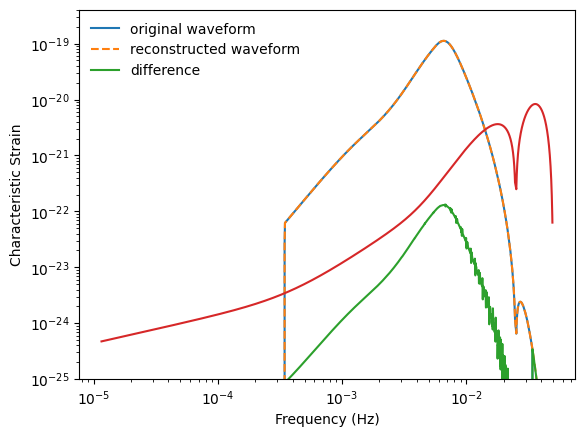

In [44]:
plt.loglog(data_frequencies, np.abs(wf_channels[0].get()) * data_frequencies, label="original waveform")
plt.loglog(data_frequencies, np.abs(rec_wave[0][0].get()) * data_frequencies, linestyle="--", label="reconstructed waveform")
plt.loglog(data_frequencies, np.abs(rec_wave[0][0].get() - wf_channels[0].get()) * data_frequencies, label="difference")
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies))
plt.ylim(1e-25,)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic Strain")
plt.legend(loc="upper left", frameon=False)

In [45]:
rec_a = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=int_params, 
    return_a=True, 
)
rec_a.shape 

(1, 4)

In [46]:
rec_ext_params = Fstat.a_to_extrinsic_vectorized(rec_a)
for k, v in rec_ext_params.items():
    print(k, v, mbhb_parameters[k])

luminosity_distance 13854.549475084315 13878.522474757385
inclination 1.6044628340636355 1.605293256574217
coalescence_phase 0.18445919232944516 0.8776822891016764
psi 0.022943495052222665 2.3804577698441056


### optimization from prior 

In [47]:
intrinsic_parameter_ranges = np.array([
    [5.5, 6.5], 
    [0.1, 1.], 
    [-0.99, 0.99], 
    [-0.99, 0.99], 
    # [mbhb_parameters["coalescence_time"]-0.01, mbhb_parameters["coalescence_time"]+0.01], 
    [t_start/DAY+3, t_end/DAY],
    [0, TWOPI], 
    [-1., 1.]
])

intrinsic_parameter_ranges

array([[ 5.5       ,  6.5       ],
       [ 0.1       ,  1.        ],
       [-0.99      ,  0.99      ],
       [-0.99      ,  0.99      ],
       [13.        , 15.        ],
       [ 0.        ,  6.28318531],
       [-1.        ,  1.        ]])

In [48]:
from scipy.optimize import differential_evolution

n_dim_int = len(Fstatistics.intrinsic_parameter_names)
print("number of parameters to be optimized:", n_dim_int)

def cost_function(norm_int_params):
    """   
        norm_int_params: shape (Nparams, Nevent), normalized to (0, 1)
    """
    int_params = norm_int_params.transpose() * (intrinsic_parameter_ranges[:, 1] - intrinsic_parameter_ranges[:, 0]) + intrinsic_parameter_ranges[:, 0] # (Nevent, Nparams)
    params_in = Fstat.IntParamArr2ParamDict(int_params.transpose()) # (Nparams, Nevent) -> dictionary, each item (Nevent)
    return -Fstat.calculate_Fstat_vectorized(intrinsic_parameters=params_in) # (Nevent)

lower_bounds = np.zeros(n_dim_int) 
upper_bounds = np.ones(n_dim_int) 
bounds = np.array([lower_bounds, upper_bounds]).T # (Nparams, 2)

DE_result = differential_evolution(
    func=cost_function,
    bounds=bounds,
    x0=None,
    strategy='best1exp',
    # strategy='rand1bin',
    maxiter=5000,
    popsize=10*n_dim_int,
    # popsize=6*n_dim_int, 
    tol=1e-7,
    atol=1e-9,
    mutation=(0.4, 0.95),
    recombination=0.7,
    disp=False,
    polish=False,
    vectorized=True,
)
print(DE_result)

number of parameters to be optimized: 7


/home/ps/miniconda3/envs/tdc/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'vectorized' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


             message: Optimization terminated successfully.
             success: True
                 fun: -388626.74835959607
                   x: [ 2.173e-01  7.736e-02  1.350e-01  3.575e-01
                        3.735e-02  4.783e-01  1.246e-01]
                 nit: 456
                nfev: 457
          population: [[ 2.173e-01  7.736e-02 ...  4.783e-01  1.246e-01]
                       [ 2.174e-01  7.735e-02 ...  4.783e-01  1.235e-01]
                       ...
                       [ 2.173e-01  7.728e-02 ...  4.780e-01  1.290e-01]
                       [ 2.173e-01  7.740e-02 ...  4.781e-01  1.266e-01]]
 population_energies: [-3.886e+05 -3.886e+05 ... -3.886e+05 -3.886e+05]


### reconstruct parameters and waveforms 

In [49]:
searched_int_params = Fstat.IntParamArr2ParamDict(DE_result.x * (intrinsic_parameter_ranges[:, 1] - intrinsic_parameter_ranges[:, 0]) + intrinsic_parameter_ranges[:, 0])

searched_a = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=searched_int_params, 
    return_a=True, 
) # (1, 4)
searched_ext_params = Fstat.a_to_extrinsic_vectorized(searched_a)

searched_params = dict(searched_int_params, **searched_ext_params)

for k, v in searched_params.items():
    print(k, mbhb_parameters[k], v, np.abs(v-mbhb_parameters[k]))

chirp_mass 521637.04439824284 521606.05847639777 30.98592184507288
mass_ratio 0.16922896640748814 0.16962754532946406 0.0003985789219759228
spin_1z -0.7194019305921477 -0.7226941221669134 0.0032921915747656794
spin_2z -0.29062389607873584 -0.2821122909759073 0.008511605102828557
coalescence_time 13.071193927362142 13.074709617559838 0.003515690197696486
longitude 3.706707335028864 3.005040970129654 0.7016663648992099
latitude 0.20056018449895902 -0.849230556114202 1.049790740613161
luminosity_distance 13878.522474757385 12073.691106435273 1804.8313683221113
inclination 1.605293256574217 1.543866317627671 0.06142693894654605
coalescence_phase 0.8776822891016764 0.15528154510018388 0.7224007440014926
psi 2.3804577698441056 0.056077379945609275 2.3243803898984963


In [50]:
np.cos(mbhb_parameters["inclination"]), np.cos(searched_params["inclination"])

(-0.03449008807593002, 0.026926754230838987)

(3, 21077)

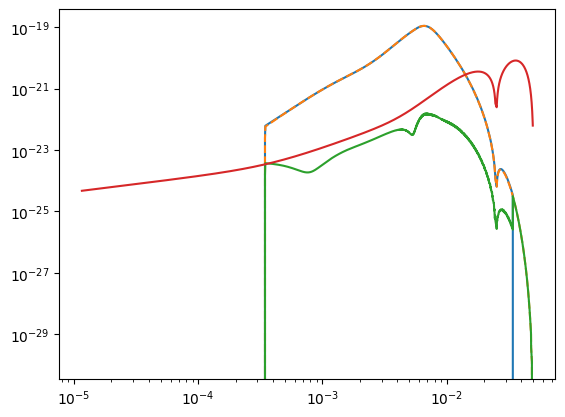

In [58]:
searched_wf = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=searched_int_params, 
    return_recovered_wave=True
)[:, 0, :]

# searched_wf = FDTDI_GPU.Response(
#     searched_params, 
#     data_frequencies_GPU, 
#     **response_kwargs_GPU
# )

plt.loglog(data_frequencies, np.abs(wf_channels[0].get()) * data_frequencies)
plt.loglog(data_frequencies, np.abs(searched_wf[0].get()) * data_frequencies, linestyle="--")
plt.loglog(data_frequencies, np.abs(searched_wf[0].get() - wf_channels[0].get()) * data_frequencies, linestyle="-")
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies))

searched_wf.shape 

## Fisher analysis 

In [52]:
def fisher_waveform_wrapper(param_dict, frequencies):
    res = FDTDI_GPU.Response(
        parameters=param_dict, 
        freqs=xp.array(frequencies),  
        **response_kwargs_GPU, 
    )
    return res.get()

# set initial steps 
analyze_param_step_dict = {
    'chirp_mass': 10.,
    'mass_ratio': 0.01,
    'spin_1z': 0.01,
    'spin_2z': 0.01,
    'coalescence_time': 0.001,
    'coalescence_phase': 0.001,
    'luminosity_distance': 10.,
    'inclination': 0.01,
    'longitude': 0.01,
    'latitude': 0.01,
    'psi': 0.01
    }
for k, v in analyze_param_step_dict.items():
    analyze_param_step_dict[k] = -v 

FIM = MultiChannelFisher(
    waveform_generator=fisher_waveform_wrapper, 
    # param_dict=mbhb_parameters, 
    param_dict=searched_params, 
    analyze_param_step_dict=analyze_param_step_dict, 
    frequency=data_frequencies, 
    inverse_covariance=InvCovMat, 
    verbose=1,
)

FIM.auto_test_step()
FIM.calculate_Fisher()
FIM.calculate_errors() 

11 parameters in total: ['chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'longitude', 'latitude', 'luminosity_distance', 'inclination', 'coalescence_phase', 'psi']
11 analyzed parameters: ['chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'coalescence_phase', 'luminosity_distance', 'inclination', 'longitude', 'latitude', 'psi']
parameters whose steps should be tested: ['chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'coalescence_phase', 'luminosity_distance', 'inclination', 'longitude', 'latitude', 'psi']

 ========= testing parameter chirp_mass ==========
error = 4.6037258742310705
shift = 5.0 relative diff = 3.3641413477623634e-06
shift of parameter chirp_mass is 5.0

 ========= testing parameter mass_ratio ==========
error = 0.0052627659629827924
shift = 0.005 relative diff = 0.050097872738902254
error = 0.005093752747826675
shift = 0.0025 relative diff = 0.058218456942289505
error = 0.005045675916354665
shift = 0.00125

In [53]:
FIM.param_errors

{'chirp_mass': 204.38803498227006,
 'mass_ratio': 0.0010471471830816631,
 'spin_1z': 0.01889079629184376,
 'spin_2z': 0.1319338158545692,
 'coalescence_time': 0.0001153830508533252,
 'coalescence_phase': 0.006422731085730488,
 'luminosity_distance': 1563.1309051989012,
 'inclination': 0.0040172949496830685,
 'longitude': 0.05170063656087656,
 'latitude': 0.13641341595744744,
 'psi': 0.07654739076126552}